In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib
import os

In [2]:
print(sns.__version__)

0.9.0


In [3]:
lon = {'Californian':[-155,-95], 'Peruvian':[-115,-55], 'Namibian':[-25,35]}
lat = {'Californian':[5,55], 'Peruvian':[-45,5], 'Namibian':[-45,15]}
name_convert = {'Peru':'Peruvian', 'California':'Californian', 'Namibia':'Namibian'}

to_plot_rain = ['rain_prob', 'rain_mean']
to_plot_lwp = ['lwp']

formatted_names = {'rain_prob':'Probability of Rain (1)', 'rain_mean':'Mean rain (??)', 'lwp':'Liquid Water Path (kg/m2)'}

In [4]:
def assign_place(poc_df):
    res = []
    # We only need to test one of the slices of the POC
    single_slice_of_poc = poc_df.iloc[0]
    for place, value in lon.items():
        if single_slice_of_poc.latitude > lat[place][0] and single_slice_of_poc.latitude < lat[place][1] and \
          single_slice_of_poc.longitude >lon[place][0] and single_slice_of_poc.longitude < lon[place][1]:
            res.append(place)
    # Check we matched exactly one place
#     print(res)
#     assert len(res) == 1, 'summin went wrong ere!'
    if len(res) == 1:
        res = res[0]
    else:
        res = None
    return res

def get_combined_df(pickle_file, stripe_width):
    """
    
    stripe_width # Number of kilometers each stripe represents
    
    """
    csv_file = pickle_file + '.csv'
    if os.path.isfile(csv_file):
        return pd.read_csv(csv_file)
    else:
        with open(pickle_file, 'rb') as handle:
            data = pickle.load(handle)

    example_POC = next((d for d in data if d is not None))
    print(example_POC)
    POCs = [len(d['latitude']) for d in data if d is not None]
    n_POCs = sum(POCs)
    print("Number of POCs found: {}".format(n_POCs))

    n_stripes = len(example_POC['latitude'][0])  # No. of stripes (assuming all the same)

    n_stripes_from_boundary = (math.ceil(n_stripes/2)-0.5)

    # Combine all the dictionaries into one with stacked arrays
    pandas_data = {}
    for key, value in example_POC.items():
        pandas_data[key] = np.zeros((0, n_stripes))

    for image in data:
        if image: 
            for variable, array in image.items():
                if variable in pandas_data:
                    pandas_data[variable] = np.append(pandas_data[variable], np.asarray(array), axis=0)
                    pandas_data[variable] = pd.DataFrame(pandas_data[variable])

    pandas_long_form = pd.DataFrame()
    for variable, array in pandas_data.items():
        pandas_long_form[variable] = array.stack()

    pandas_long_form['Distance from Boundary (km)'] = (pandas_long_form.index.get_level_values(1).values-n_stripes_from_boundary)*stripe_width
    
    # Group by POC, apply the assignment function, then reindex to broadcast across the slices
    pandas_long_form['Location'] = pandas_long_form.groupby(level=0, axis=0).apply(assign_place).reindex(pandas_long_form.index, level=0)
    
#   # Save the df for next time
    pandas_long_form.to_csv(csv_file)
    return pandas_long_form

In [5]:
df = get_combined_df('results/results_all_data.pickle', stripe_width=10)

3


ValueError: Could not interpret input 'rain_mean'

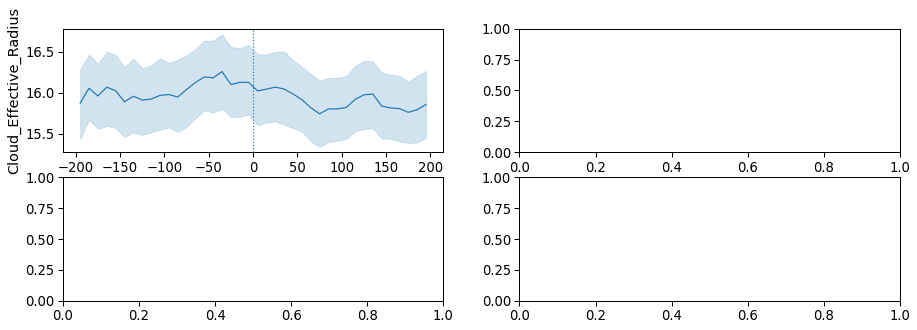

In [6]:
no_variables=len(to_plot_rain+to_plot_lwp)
print(no_variables)
sns.set_context('paper', font_scale=1.5)

index = 0
fig, ax = plt.subplots(2, 2, figsize = (15, 5*math.floor(no_variables/2)))


current_ax=ax[0, 0]
sns.lineplot(x='Distance from Boundary (km)', y='Cloud_Effective_Radius', data=df, hue='Location', ax=current_ax, ci=68)
current_ax.axvline(x=0, linestyle=':')
# current_ax.set_xlabel('')
current_ax.set_ylabel("Cloud_Effective_Radius")
# current_ax.set_xlim(-75,200)
# current_ax.set_ylim(0.0,0.1)
handles, labels = current_ax.get_legend_handles_labels()
current_ax.get_legend().remove()

current_ax=ax[1, 0]
sns.lineplot(x='Distance from Boundary (km)', y='rain_mean', data=df, hue='Location', ax=current_ax, ci=68)
current_ax.axvline(x=0, linestyle=':')
# current_ax.set_xlabel('')
current_ax.set_ylabel(formatted_names['rain_mean'])
# current_ax.set_xlim(-75,200)
# current_ax.set_ylim(0.0,0.02)
handles, labels = current_ax.get_legend_handles_labels()
current_ax.get_legend().remove()

current_ax=ax[0, 1]
sns.lineplot(x='Distance from Boundary (km)', y='lwp', data=df, hue='Location', ax=current_ax, ci=68)
current_ax.axvline(x=0, linestyle=':')
# current_ax.set_xlabel('')
current_ax.set_ylabel(formatted_names['lwp'])
# current_ax.set_xlim(-75,200)
# current_ax.set_ylim(0.05,0.1)
handles, labels = current_ax.get_legend_handles_labels()
current_ax.get_legend().remove()
    
# ax[2,0].set_xlabel('Distance from Boundary (km)')
    
# area_ax.grid()
# area_ax.set_xticklabels([f"$10^{int(t)}$" for t in area_ax.get_xticks()])
# area_ax.set_xlabel("Area (km)")
# area_ax.set_ylabel("Probability (1)")

    
fig.legend(handles[1:], ['California', 'Namibia', 'Peru'], ncol=3, title='Location', loc='lower center', bbox_to_anchor=(0.4, 0.01))
# fig.tight_layout()
# fig.suptitle('Properties of POCs', fontsize=22)

In [ ]:
df_rain = get_combined_df('results/results_amsr2_rain.pickle', stripe_width=10)
df_lwp = get_combined_df('results/results_amsr2_lwp.pickle', stripe_width=10)

In [ ]:
no_variables=len(to_plot_rain+to_plot_lwp)
print(no_variables)
sns.set_context('paper', font_scale=1.5)

index = 0
fig, ax = plt.subplots(2, 2, figsize = (15, 5*math.floor(no_variables/2)))


current_ax=ax[0, 0]
sns.lineplot(x='Distance from Boundary (km)', y='rain_prob', data=df_rain, hue='Location', ax=current_ax, ci=68)
current_ax.axvline(x=0, linestyle=':')
# current_ax.set_xlabel('')
current_ax.set_ylabel(formatted_names['rain_prob'])
current_ax.set_xlim(-75,200)
# current_ax.set_ylim(0.0,0.1)
handles, labels = current_ax.get_legend_handles_labels()
current_ax.get_legend().remove()

current_ax=ax[1, 0]
sns.lineplot(x='Distance from Boundary (km)', y='rain_mean', data=df_rain, hue='Location', ax=current_ax, ci=68)
current_ax.axvline(x=0, linestyle=':')
# current_ax.set_xlabel('')
current_ax.set_ylabel(formatted_names['rain_mean'])
current_ax.set_xlim(-75,200)
# current_ax.set_ylim(0.0,0.02)
handles, labels = current_ax.get_legend_handles_labels()
current_ax.get_legend().remove()

current_ax=ax[0, 1]
sns.lineplot(x='Distance from Boundary (km)', y='lwp', data=df_lwp, hue='Location', ax=current_ax, ci=68)
current_ax.axvline(x=0, linestyle=':')
# current_ax.set_xlabel('')
current_ax.set_ylabel(formatted_names['lwp'])
current_ax.set_xlim(-75,200)
# current_ax.set_ylim(0.05,0.1)
handles, labels = current_ax.get_legend_handles_labels()
current_ax.get_legend().remove()

current_ax=ax[0, 1]
sns.lineplot(x='Distance from Boundary (km)', y='lwp', data=df_lwp, hue='Location', ax=current_ax, ci=68)
current_ax.axvline(x=0, linestyle=':')
# current_ax.set_xlabel('')
current_ax.set_ylabel(formatted_names['lwp'])
# current_ax.set_xlim(-75,200)
# current_ax.set_ylim(0.05,0.1)
handles, labels = current_ax.get_legend_handles_labels()
current_ax.get_legend().remove()
    

# ax[2,0].set_xlabel('Distance from Boundary (km)')
    
# area_ax.grid()
# area_ax.set_xticklabels([f"$10^{int(t)}$" for t in area_ax.get_xticks()])
# area_ax.set_xlabel("Area (km)")
# area_ax.set_ylabel("Probability (1)")

    
fig.legend(handles[1:], ['California', 'Namibia', 'Peru'], ncol=3, title='Location', loc='lower center', bbox_to_anchor=(0.4, 0.01))
# fig.tight_layout()
# fig.suptitle('Properties of POCs', fontsize=22)